In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [6]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha=self.add_weight(name="alpha",
                                    shape=batch_input_shape[-1:],
                                    initializer="ones")
        self.beta= self.add_weight(name="beta",
                                    shape=batch_input_shape[-1:],
                                    initializer="zeros")
        super().build(batch_input_shape) # must be at the end
    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha*(X-mean)/(tf.sqrt(variance) + self.eps) +self.beta
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape
    def get_config(self):
        base_config = super.get_config()
        return {**base_config, "eps":self.eps}

In [3]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

NameError: name 'X_train' is not defined

In [ ]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# data 正規化

assert X_train_full.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train_full.shape == (60000,)
assert y_test.shape == (10000,)
X_train_full = X_train_full.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_valid, X_train= X_train_full[:5000], X_train_full[5000:]
y_valid, y_train= y_train_full[:5000], y_train_full[5000:]

(-0.5, 27.5, 27.5, -0.5)

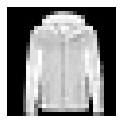

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[0], cmap="gray")
plt.axis("off")

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [11]:
n_epochs=5
batch_size = 32
n_steps=len(X_train)//batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [12]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics= " - ".join(["{}:{:.4f}".format(m.name, m.result())
                         for m in [loss]+(metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total)+metrics, end=end)

In [13]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [39]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)#要素ごと加算する
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
55000/55000 - mean:0.4947 - sparse_categorical_accuracy:0.8210
Epoch 2/5
4224/55000 - mean:0.4043 - sparse_categorical_accuracy:0.8620

KeyboardInterrupt: 

In [14]:
from tqdm import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

Epoch 1/5:   3%|▋                     | 56/1718 [00:00<00:22, 73.37it/s, loss=0.995, sparse_categorical_accuracy=0.661]


Epoch 1/5:   7%|█▍                   | 114/1718 [00:01<00:21, 73.29it/s, loss=0.801, sparse_categorical_accuracy=0.718]


Epoch 1/5:  10%|██▏                  | 174/1718 [00:02<00:19, 79.38it/s, loss=0.711, sparse_categorical_accuracy=0.749]


Epoch 1/5:  13%|██▊                  | 226/1718 [00:03<00:19, 77.89it/s, loss=0.689, sparse_categorical_accuracy=0.758]


Epoch 1/5:  17%|███▌                 | 288/1718 [00:03<00:18, 79.19it/s, loss=0.661, sparse_categorical_accuracy=0.767]


Epoch 1/5:  20%|████▎                | 350/1718 [00:04<00:16, 80.99it/s, loss=0.637, sparse_categorical_accuracy=0.774]


Epoch 1/5:  24%|█████                | 410/1718 [00:05<00:16, 79.01it/s, loss=0.626, sparse_categorical_accuracy=0.776]


Epoch 1/5:  27%|█████▋               | 467/1718 [00:06<00:17, 70.36it/s, loss=0.613, sparse_categorical_accuracy=0.782]


Epoch 1/5:  30%|██████▍              | 523/1718 [00:07<00:17, 69.74it/s, loss=0.597, sparse_categorical_accuracy=0.787]


Epoch 1/5:  34%|███████▊               | 581/1718 [00:07<00:14, 79.01it/s, loss=0.59, sparse_categorical_accuracy=0.79]


Epoch 1/5:  37%|███████▊             | 644/1718 [00:08<00:12, 85.18it/s, loss=0.578, sparse_categorical_accuracy=0.794]


Epoch 1/5:  41%|████████▌            | 698/1718 [00:09<00:12, 84.14it/s, loss=0.571, sparse_categorical_accuracy=0.795]


Epoch 1/5:  44%|█████████▎           | 761/1718 [00:09<00:11, 81.06it/s, loss=0.562, sparse_categorical_accuracy=0.798]


Epoch 1/5:  48%|███████████            | 823/1718 [00:10<00:10, 82.93it/s, loss=0.554, sparse_categorical_accuracy=0.8]


Epoch 1/5:  51%|██████████▋          | 878/1718 [00:11<00:10, 80.87it/s, loss=0.548, sparse_categorical_accuracy=0.802]


Epoch 1/5:  55%|███████████▌         | 942/1718 [00:12<00:09, 84.29it/s, loss=0.544, sparse_categorical_accuracy=0.804]


Epoch 1/5:  58%|████████████▊         | 996/1718 [00:12<00:08, 87.24it/s, loss=0.54, sparse_categorical_accuracy=0.806]


Epoch 1/5:  62%|████████████▎       | 1059/1718 [00:13<00:07, 83.68it/s, loss=0.534, sparse_categorical_accuracy=0.808]


Epoch 1/5:  65%|█████████████▋       | 1122/1718 [00:14<00:07, 80.90it/s, loss=0.529, sparse_categorical_accuracy=0.81]


Epoch 1/5:  68%|█████████████▋      | 1176/1718 [00:14<00:06, 79.67it/s, loss=0.524, sparse_categorical_accuracy=0.812]


Epoch 1/5:  72%|███████████████▏     | 1240/1718 [00:15<00:05, 85.78it/s, loss=0.52, sparse_categorical_accuracy=0.813]


Epoch 1/5:  75%|███████████████     | 1294/1718 [00:16<00:05, 83.77it/s, loss=0.518, sparse_categorical_accuracy=0.814]


Epoch 1/5:  79%|███████████████▊    | 1357/1718 [00:17<00:04, 74.63it/s, loss=0.514, sparse_categorical_accuracy=0.816]


Epoch 1/5:  83%|████████████████▌   | 1419/1718 [00:17<00:03, 83.62it/s, loss=0.509, sparse_categorical_accuracy=0.817]


Epoch 1/5:  86%|█████████████████▏  | 1472/1718 [00:18<00:03, 79.78it/s, loss=0.506, sparse_categorical_accuracy=0.818]


Epoch 1/5:  89%|█████████████████▉  | 1536/1718 [00:19<00:02, 78.22it/s, loss=0.504, sparse_categorical_accuracy=0.819]


Epoch 1/5:  93%|███████████████████▍ | 1593/1718 [00:20<00:01, 72.44it/s, loss=0.501, sparse_categorical_accuracy=0.82]


Epoch 1/5:  96%|█████████████████████▏| 1653/1718 [00:20<00:00, 78.15it/s, loss=0.5, sparse_categorical_accuracy=0.821]


Epoch 1/5:  99%|███████████████████▊| 1707/1718 [00:21<00:00, 82.59it/s, loss=0.498, sparse_categorical_accuracy=0.821]


Epoch 2/5:   3%|▋                     | 51/1718 [00:00<00:20, 79.82it/s, loss=0.417, sparse_categorical_accuracy=0.857]


Epoch 2/5:   7%|█▍                   | 113/1718 [00:01<00:19, 81.63it/s, loss=0.403, sparse_categorical_accuracy=0.856]


Epoch 2/5:  10%|██▏                   | 167/1718 [00:02<00:18, 84.02it/s, loss=0.399, sparse_categorical_accuracy=0.86]


Epoch 2/5:  13%|██▊                  | 230/1718 [00:02<00:19, 77.25it/s, loss=0.405, sparse_categorical_accuracy=0.858]


Epoch 2/5:  17%|███▌                 | 290/1718 [00:03<00:19, 74.78it/s, loss=0.413, sparse_categorical_accuracy=0.856]


Epoch 2/5:  20%|████▍                 | 350/1718 [00:04<00:18, 75.86it/s, loss=0.42, sparse_categorical_accuracy=0.851]


Epoch 2/5:  24%|█████▏                | 407/1718 [00:05<00:17, 76.05it/s, loss=0.42, sparse_categorical_accuracy=0.852]


Epoch 2/5:  27%|█████▉                | 468/1718 [00:06<00:15, 82.62it/s, loss=0.42, sparse_categorical_accuracy=0.853]


Epoch 2/5:  30%|██████▎              | 521/1718 [00:06<00:14, 83.21it/s, loss=0.417, sparse_categorical_accuracy=0.854]


Epoch 2/5:  34%|███████▏             | 584/1718 [00:07<00:13, 85.68it/s, loss=0.419, sparse_categorical_accuracy=0.852]


Epoch 2/5:  38%|████████▎             | 647/1718 [00:08<00:12, 86.75it/s, loss=0.422, sparse_categorical_accuracy=0.85]


Epoch 2/5:  41%|████████▌            | 701/1718 [00:08<00:12, 79.04it/s, loss=0.421, sparse_categorical_accuracy=0.849]


Epoch 2/5:  44%|█████████▎           | 761/1718 [00:09<00:12, 75.82it/s, loss=0.424, sparse_categorical_accuracy=0.849]


Epoch 2/5:  48%|██████████▌           | 822/1718 [00:10<00:11, 80.27it/s, loss=0.422, sparse_categorical_accuracy=0.85]


Epoch 2/5:  51%|███████████▏          | 876/1718 [00:11<00:10, 82.69it/s, loss=0.422, sparse_categorical_accuracy=0.85]


Epoch 2/5:  55%|████████████▌          | 939/1718 [00:11<00:09, 82.03it/s, loss=0.42, sparse_categorical_accuracy=0.85]


Epoch 2/5:  58%|████████████▎        | 1003/1718 [00:12<00:08, 84.48it/s, loss=0.42, sparse_categorical_accuracy=0.851]


Epoch 2/5:  62%|████████████▉        | 1057/1718 [00:13<00:08, 80.30it/s, loss=0.42, sparse_categorical_accuracy=0.851]


Epoch 2/5:  65%|█████████████▋       | 1118/1718 [00:14<00:07, 82.46it/s, loss=0.421, sparse_categorical_accuracy=0.85]


Epoch 2/5:  69%|██████████████▍      | 1180/1718 [00:14<00:06, 80.54it/s, loss=0.42, sparse_categorical_accuracy=0.851]


Epoch 2/5:  72%|███████████████      | 1234/1718 [00:15<00:06, 80.11it/s, loss=0.42, sparse_categorical_accuracy=0.851]


Epoch 2/5:  76%|███████████████     | 1299/1718 [00:16<00:04, 87.22it/s, loss=0.418, sparse_categorical_accuracy=0.852]


Epoch 2/5:  79%|███████████████▊    | 1353/1718 [00:17<00:04, 83.19it/s, loss=0.419, sparse_categorical_accuracy=0.851]


Epoch 2/5:  82%|████████████████▍   | 1416/1718 [00:17<00:03, 82.39it/s, loss=0.416, sparse_categorical_accuracy=0.851]


Epoch 2/5:  86%|█████████████████▏  | 1477/1718 [00:18<00:03, 79.05it/s, loss=0.416, sparse_categorical_accuracy=0.851]


Epoch 2/5:  89%|█████████████████▊  | 1531/1718 [00:19<00:02, 79.56it/s, loss=0.415, sparse_categorical_accuracy=0.852]


Epoch 2/5:  93%|██████████████████▌ | 1594/1718 [00:20<00:01, 66.97it/s, loss=0.414, sparse_categorical_accuracy=0.852]


Epoch 2/5:  96%|███████████████████▏| 1651/1718 [00:20<00:00, 72.76it/s, loss=0.414, sparse_categorical_accuracy=0.852]


Epoch 2/5:  99%|███████████████████▉| 1708/1718 [00:21<00:00, 70.24it/s, loss=0.415, sparse_categorical_accuracy=0.852]


Epoch 3/5:   3%|▋                     | 50/1718 [00:00<00:22, 74.31it/s, loss=0.364, sparse_categorical_accuracy=0.865]


Epoch 3/5:   6%|█▎                   | 108/1718 [00:01<00:20, 77.33it/s, loss=0.382, sparse_categorical_accuracy=0.864]


Epoch 3/5:  10%|██                    | 165/1718 [00:02<00:20, 77.26it/s, loss=0.397, sparse_categorical_accuracy=0.86]


Epoch 3/5:  13%|██▊                  | 225/1718 [00:02<00:19, 78.05it/s, loss=0.399, sparse_categorical_accuracy=0.859]


Epoch 3/5:  17%|███▍                 | 284/1718 [00:03<00:18, 79.20it/s, loss=0.403, sparse_categorical_accuracy=0.858]


Epoch 3/5:  20%|████▍                 | 344/1718 [00:04<00:16, 81.64it/s, loss=0.402, sparse_categorical_accuracy=0.86]


Epoch 3/5:  24%|████▉                | 406/1718 [00:05<00:16, 80.35it/s, loss=0.398, sparse_categorical_accuracy=0.861]


Epoch 3/5:  27%|█████▉                | 465/1718 [00:05<00:15, 78.77it/s, loss=0.396, sparse_categorical_accuracy=0.86]


Epoch 3/5:  30%|██████▎              | 518/1718 [00:06<00:14, 81.86it/s, loss=0.398, sparse_categorical_accuracy=0.859]


Epoch 3/5:  34%|███████              | 581/1718 [00:07<00:13, 85.72it/s, loss=0.396, sparse_categorical_accuracy=0.859]


Epoch 3/5:  37%|███████▊             | 644/1718 [00:08<00:12, 83.83it/s, loss=0.395, sparse_categorical_accuracy=0.859]


Epoch 3/5:  41%|████████▉             | 699/1718 [00:08<00:11, 86.63it/s, loss=0.395, sparse_categorical_accuracy=0.86]


Epoch 3/5:  44%|█████████▊            | 762/1718 [00:09<00:11, 83.26it/s, loss=0.393, sparse_categorical_accuracy=0.86]


Epoch 3/5:  47%|██████████▍           | 816/1718 [00:10<00:11, 80.85it/s, loss=0.395, sparse_categorical_accuracy=0.86]


Epoch 3/5:  51%|██████████▋          | 876/1718 [00:11<00:11, 74.77it/s, loss=0.396, sparse_categorical_accuracy=0.859]


Epoch 3/5:  54%|███████████▍         | 936/1718 [00:11<00:09, 78.28it/s, loss=0.397, sparse_categorical_accuracy=0.858]


Epoch 3/5:  58%|████████████▏        | 999/1718 [00:12<00:08, 83.37it/s, loss=0.395, sparse_categorical_accuracy=0.858]


Epoch 3/5:  61%|████████████▎       | 1053/1718 [00:13<00:08, 80.73it/s, loss=0.394, sparse_categorical_accuracy=0.859]


Epoch 3/5:  65%|████████████▉       | 1115/1718 [00:13<00:07, 79.79it/s, loss=0.395, sparse_categorical_accuracy=0.859]


Epoch 3/5:  68%|█████████████▌      | 1170/1718 [00:14<00:06, 83.67it/s, loss=0.395, sparse_categorical_accuracy=0.859]


Epoch 3/5:  72%|███████████████      | 1233/1718 [00:15<00:05, 85.48it/s, loss=0.393, sparse_categorical_accuracy=0.86]


Epoch 3/5:  75%|███████████████▊     | 1297/1718 [00:16<00:05, 79.08it/s, loss=0.392, sparse_categorical_accuracy=0.86]


Epoch 3/5:  79%|████████████████▌    | 1351/1718 [00:16<00:04, 82.28it/s, loss=0.39, sparse_categorical_accuracy=0.861]


Epoch 3/5:  82%|█████████████████▎   | 1416/1718 [00:17<00:03, 87.24it/s, loss=0.39, sparse_categorical_accuracy=0.861]


Epoch 3/5:  86%|█████████████████▏  | 1473/1718 [00:18<00:02, 87.43it/s, loss=0.389, sparse_categorical_accuracy=0.861]


Epoch 3/5:  89%|█████████████████▊  | 1530/1718 [00:18<00:02, 89.71it/s, loss=0.389, sparse_categorical_accuracy=0.861]


Epoch 3/5:  93%|██████████████████▌ | 1594/1718 [00:19<00:01, 86.57it/s, loss=0.389, sparse_categorical_accuracy=0.861]


Epoch 3/5:  96%|███████████████████▏| 1650/1718 [00:20<00:00, 82.66it/s, loss=0.389, sparse_categorical_accuracy=0.861]


Epoch 3/5:  99%|███████████████████▊| 1706/1718 [00:20<00:00, 77.33it/s, loss=0.387, sparse_categorical_accuracy=0.861]


Epoch 4/5:   3%|▋                      | 47/1718 [00:00<00:18, 89.77it/s, loss=0.359, sparse_categorical_accuracy=0.87]


Epoch 4/5:   6%|█▍                    | 110/1718 [00:01<00:18, 85.08it/s, loss=0.38, sparse_categorical_accuracy=0.864]


Epoch 4/5:  10%|██                   | 173/1718 [00:02<00:18, 85.62it/s, loss=0.379, sparse_categorical_accuracy=0.865]


Epoch 4/5:  13%|██▊                  | 227/1718 [00:02<00:17, 85.27it/s, loss=0.373, sparse_categorical_accuracy=0.866]


Epoch 4/5:  17%|███▋                  | 290/1718 [00:03<00:16, 86.01it/s, loss=0.37, sparse_categorical_accuracy=0.868]


Epoch 4/5:  20%|████▏                | 344/1718 [00:04<00:16, 82.87it/s, loss=0.368, sparse_categorical_accuracy=0.868]


Epoch 4/5:  24%|████▉                | 406/1718 [00:04<00:17, 75.67it/s, loss=0.369, sparse_categorical_accuracy=0.868]


Epoch 4/5:  27%|█████▋               | 467/1718 [00:05<00:16, 75.97it/s, loss=0.371, sparse_categorical_accuracy=0.867]


Epoch 4/5:  31%|██████▋               | 526/1718 [00:06<00:16, 73.22it/s, loss=0.37, sparse_categorical_accuracy=0.868]


Epoch 4/5:  34%|███████▏             | 588/1718 [00:07<00:13, 80.96it/s, loss=0.371, sparse_categorical_accuracy=0.866]


Epoch 4/5:  37%|███████▊             | 644/1718 [00:08<00:16, 65.19it/s, loss=0.372, sparse_categorical_accuracy=0.866]


Epoch 4/5:  41%|████████▌            | 705/1718 [00:08<00:12, 78.95it/s, loss=0.375, sparse_categorical_accuracy=0.865]


Epoch 4/5:  44%|█████████▎           | 759/1718 [00:09<00:11, 84.84it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  48%|██████████           | 823/1718 [00:10<00:10, 85.43it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  51%|██████████▋          | 877/1718 [00:10<00:09, 86.88it/s, loss=0.373, sparse_categorical_accuracy=0.865]


Epoch 4/5:  55%|███████████▌         | 943/1718 [00:11<00:08, 87.56it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  58%|████████████▏        | 997/1718 [00:12<00:08, 85.97it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  62%|████████████▎       | 1062/1718 [00:12<00:07, 86.75it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  65%|█████████████       | 1118/1718 [00:13<00:06, 88.29it/s, loss=0.375, sparse_categorical_accuracy=0.865]


Epoch 4/5:  69%|█████████████▋      | 1181/1718 [00:14<00:06, 83.62it/s, loss=0.376, sparse_categorical_accuracy=0.865]


Epoch 4/5:  72%|██████████████▍     | 1236/1718 [00:15<00:05, 87.76it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  75%|███████████████     | 1294/1718 [00:15<00:04, 89.16it/s, loss=0.375, sparse_categorical_accuracy=0.865]


Epoch 4/5:  79%|███████████████▊    | 1357/1718 [00:16<00:04, 87.40it/s, loss=0.374, sparse_categorical_accuracy=0.866]


Epoch 4/5:  82%|████████████████▍   | 1413/1718 [00:17<00:03, 87.33it/s, loss=0.374, sparse_categorical_accuracy=0.866]


Epoch 4/5:  86%|█████████████████▏  | 1477/1718 [00:17<00:02, 86.71it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  89%|█████████████████▊  | 1533/1718 [00:18<00:02, 87.49it/s, loss=0.374, sparse_categorical_accuracy=0.865]


Epoch 4/5:  93%|██████████████████▌ | 1598/1718 [00:19<00:01, 90.60it/s, loss=0.375, sparse_categorical_accuracy=0.865]


Epoch 4/5:  96%|███████████████████▎| 1656/1718 [00:19<00:00, 88.82it/s, loss=0.376, sparse_categorical_accuracy=0.865]


All epochs:  80%|█████████████████████████████████████████████████████████▌              | 4/5 [01:25<00:21, 21.08s/it]


Epoch 5/5:   3%|▋                     | 50/1718 [00:00<00:18, 90.36it/s, loss=0.378, sparse_categorical_accuracy=0.857]


Epoch 5/5:   7%|█▍                   | 119/1718 [00:01<00:17, 92.20it/s, loss=0.372, sparse_categorical_accuracy=0.862]


Epoch 5/5:  10%|██▏                  | 179/1718 [00:01<00:16, 91.19it/s, loss=0.386, sparse_categorical_accuracy=0.858]


Epoch 5/5:  14%|███                   | 239/1718 [00:02<00:16, 90.29it/s, loss=0.383, sparse_categorical_accuracy=0.86]


Epoch 5/5:  17%|███▋                 | 299/1718 [00:03<00:15, 91.69it/s, loss=0.383, sparse_categorical_accuracy=0.859]


Epoch 5/5:  21%|████▊                  | 359/1718 [00:03<00:14, 90.96it/s, loss=0.38, sparse_categorical_accuracy=0.86]


Epoch 5/5:  24%|█████                | 419/1718 [00:04<00:14, 91.32it/s, loss=0.375, sparse_categorical_accuracy=0.863]


Epoch 5/5:  28%|█████▊               | 479/1718 [00:05<00:13, 93.32it/s, loss=0.376, sparse_categorical_accuracy=0.862]


Epoch 5/5:  31%|██████▉               | 539/1718 [00:05<00:12, 92.03it/s, loss=0.38, sparse_categorical_accuracy=0.862]


Epoch 5/5:  35%|███████▎             | 599/1718 [00:06<00:12, 91.57it/s, loss=0.384, sparse_categorical_accuracy=0.861]


Epoch 5/5:  38%|████████▍             | 658/1718 [00:07<00:11, 89.42it/s, loss=0.38, sparse_categorical_accuracy=0.861]


Epoch 5/5:  42%|█████████▏            | 714/1718 [00:07<00:11, 89.84it/s, loss=0.384, sparse_categorical_accuracy=0.86]


Epoch 5/5:  45%|█████████▍           | 774/1718 [00:08<00:10, 90.08it/s, loss=0.382, sparse_categorical_accuracy=0.861]


Epoch 5/5:  48%|██████████▋           | 833/1718 [00:09<00:09, 91.34it/s, loss=0.38, sparse_categorical_accuracy=0.861]


Epoch 5/5:  52%|███████████▍          | 893/1718 [00:09<00:09, 91.49it/s, loss=0.38, sparse_categorical_accuracy=0.861]


Epoch 5/5:  55%|████████████▏         | 953/1718 [00:10<00:08, 90.44it/s, loss=0.38, sparse_categorical_accuracy=0.861]


Epoch 5/5:  59%|███████████▊        | 1013/1718 [00:11<00:07, 91.77it/s, loss=0.379, sparse_categorical_accuracy=0.862]


Epoch 5/5:  62%|█████████████        | 1073/1718 [00:11<00:07, 91.39it/s, loss=0.38, sparse_categorical_accuracy=0.861]


Epoch 5/5:  66%|█████████████▏      | 1132/1718 [00:12<00:06, 90.37it/s, loss=0.379, sparse_categorical_accuracy=0.862]


Epoch 5/5:  69%|█████████████▉      | 1192/1718 [00:13<00:05, 90.42it/s, loss=0.379, sparse_categorical_accuracy=0.862]


Epoch 5/5:  73%|██████████████▌     | 1252/1718 [00:13<00:05, 89.20it/s, loss=0.378, sparse_categorical_accuracy=0.863]


Epoch 5/5:  76%|███████████████▎    | 1311/1718 [00:14<00:04, 90.32it/s, loss=0.377, sparse_categorical_accuracy=0.863]


Epoch 5/5:  80%|███████████████▉    | 1370/1718 [00:15<00:03, 92.17it/s, loss=0.376, sparse_categorical_accuracy=0.863]


Epoch 5/5:  83%|████████████████▋   | 1430/1718 [00:15<00:03, 91.12it/s, loss=0.375, sparse_categorical_accuracy=0.863]


Epoch 5/5:  87%|█████████████████▎  | 1490/1718 [00:16<00:02, 91.67it/s, loss=0.375, sparse_categorical_accuracy=0.863]


Epoch 5/5:  90%|██████████████████  | 1550/1718 [00:17<00:01, 92.19it/s, loss=0.373, sparse_categorical_accuracy=0.864]


Epoch 5/5:  94%|██████████████████▋ | 1609/1718 [00:17<00:01, 88.82it/s, loss=0.371, sparse_categorical_accuracy=0.864]


Epoch 5/5:  97%|███████████████████▍| 1669/1718 [00:18<00:00, 91.59it/s, loss=0.371, sparse_categorical_accuracy=0.864]


All epochs: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [01:44<00:00, 20.81s/it]


In [70]:
# different optimizer with a different learning rate for the upper layers
# and the lower layers
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [72]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
from tqdm import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

Epoch 1/5:   7%|█▍                    | 113/1718 [00:01<00:17, 93.25it/s, loss=2.06, sparse_categorical_accuracy=0.312]


Epoch 1/5:  14%|██▉                   | 234/1718 [00:02<00:15, 95.78it/s, loss=1.82, sparse_categorical_accuracy=0.445]


Epoch 1/5:  21%|████▊                  | 356/1718 [00:03<00:13, 98.73it/s, loss=1.66, sparse_categorical_accuracy=0.51]


Epoch 1/5:  28%|██████                | 476/1718 [00:05<00:13, 94.36it/s, loss=1.54, sparse_categorical_accuracy=0.549]


Epoch 1/5:  35%|███████▋              | 596/1718 [00:06<00:11, 93.89it/s, loss=1.44, sparse_categorical_accuracy=0.578]


Epoch 1/5:  42%|█████████▏            | 716/1718 [00:07<00:10, 93.54it/s, loss=1.36, sparse_categorical_accuracy=0.603]


Epoch 1/5:  49%|██████████▋           | 836/1718 [00:08<00:09, 92.77it/s, loss=1.29, sparse_categorical_accuracy=0.621]


Epoch 1/5:  56%|████████████▏         | 956/1718 [00:10<00:08, 91.74it/s, loss=1.23, sparse_categorical_accuracy=0.635]


Epoch 1/5:  63%|█████████████▏       | 1075/1718 [00:11<00:06, 92.07it/s, loss=1.19, sparse_categorical_accuracy=0.647]


Epoch 1/5:  70%|██████████████▌      | 1195/1718 [00:12<00:05, 92.92it/s, loss=1.15, sparse_categorical_accuracy=0.658]


Epoch 1/5:  77%|████████████████     | 1316/1718 [00:14<00:04, 94.90it/s, loss=1.11, sparse_categorical_accuracy=0.666]


Epoch 1/5:  84%|█████████████████▌   | 1437/1718 [00:15<00:02, 96.91it/s, loss=1.08, sparse_categorical_accuracy=0.675]


Epoch 1/5:  90%|██████████████████▉  | 1549/1718 [00:16<00:02, 75.43it/s, loss=1.05, sparse_categorical_accuracy=0.681]


Epoch 1/5:  97%|████████████████████▍| 1674/1718 [00:18<00:00, 81.31it/s, loss=1.03, sparse_categorical_accuracy=0.687]


Epoch 2/5:   4%|▊                     | 68/1718 [00:00<00:18, 89.22it/s, loss=0.665, sparse_categorical_accuracy=0.785]


Epoch 2/5:  11%|██▎                  | 188/1718 [00:02<00:16, 92.68it/s, loss=0.671, sparse_categorical_accuracy=0.778]


Epoch 2/5:  18%|███▊                 | 308/1718 [00:03<00:15, 92.17it/s, loss=0.672, sparse_categorical_accuracy=0.778]


Epoch 2/5:  25%|█████▏               | 429/1718 [00:04<00:13, 93.50it/s, loss=0.679, sparse_categorical_accuracy=0.772]


Epoch 2/5:  32%|██████▋              | 547/1718 [00:06<00:13, 89.96it/s, loss=0.671, sparse_categorical_accuracy=0.775]


Epoch 2/5:  39%|████████▎            | 675/1718 [00:07<00:11, 87.32it/s, loss=0.671, sparse_categorical_accuracy=0.775]


Epoch 2/5:  46%|█████████▋           | 790/1718 [00:08<00:10, 86.33it/s, loss=0.668, sparse_categorical_accuracy=0.776]


Epoch 2/5:  53%|███████████          | 906/1718 [00:10<00:09, 87.45it/s, loss=0.662, sparse_categorical_accuracy=0.778]


Epoch 2/5:  60%|███████████▉        | 1025/1718 [00:11<00:07, 94.10it/s, loss=0.661, sparse_categorical_accuracy=0.778]


Epoch 2/5:  67%|█████████████▎      | 1145/1718 [00:12<00:06, 89.69it/s, loss=0.656, sparse_categorical_accuracy=0.779]


Epoch 2/5:  74%|███████████████▍     | 1266/1718 [00:14<00:04, 96.07it/s, loss=0.65, sparse_categorical_accuracy=0.781]


Epoch 2/5:  81%|████████████████▏   | 1386/1718 [00:15<00:03, 92.30it/s, loss=0.646, sparse_categorical_accuracy=0.782]


Epoch 2/5:  88%|█████████████████▌  | 1507/1718 [00:16<00:02, 88.13it/s, loss=0.643, sparse_categorical_accuracy=0.783]


Epoch 2/5:  95%|███████████████████▊ | 1625/1718 [00:17<00:00, 95.76it/s, loss=0.64, sparse_categorical_accuracy=0.784]


Epoch 3/5:   2%|▍                     | 32/1718 [00:00<00:18, 93.16it/s, loss=0.563, sparse_categorical_accuracy=0.807]


Epoch 3/5:   9%|█▊                   | 151/1718 [00:01<00:17, 87.56it/s, loss=0.581, sparse_categorical_accuracy=0.795]


Epoch 3/5:  16%|███▎                 | 267/1718 [00:03<00:15, 91.66it/s, loss=0.589, sparse_categorical_accuracy=0.791]


Epoch 3/5:  23%|████▊                | 390/1718 [00:04<00:13, 98.35it/s, loss=0.581, sparse_categorical_accuracy=0.796]


Epoch 3/5:  24%|█████                | 411/1718 [00:04<00:13, 100.10it/s, loss=0.58, sparse_categorical_accuracy=0.796]
